In [1]:
import numpy as np
import pandas as pd
import scipy.signal
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import cmath
%matplotlib inline

In [2]:
file_list = ['/home/charles/ECG-Manlio/training data/' + str(i) + '.txt' for i in range(1,31)]

In [3]:
def read_ECG_from_txt(files):
    n = len(files)
    ecg_info = []
    ecg_signals = np.zeros((n, 12, 5000))
    k = 0 #count file number
    for filename in files:
        with open(filename) as f:
            lines = [line.rstrip('\n') for line in f]
            ecg_info.append(lines[:20])
            ecg_signals[k, :, :].flat[:] = lines[20:]
        k = k + 1
    return ecg_info, ecg_signals

In [4]:
ecg_info, ecg_signals = read_ECG_from_txt(file_list)

In [5]:
ecg_signals = np.delete(ecg_signals, [2,3,4,5], 1)

In [6]:
ecg_signals.shape

(30, 8, 5000)

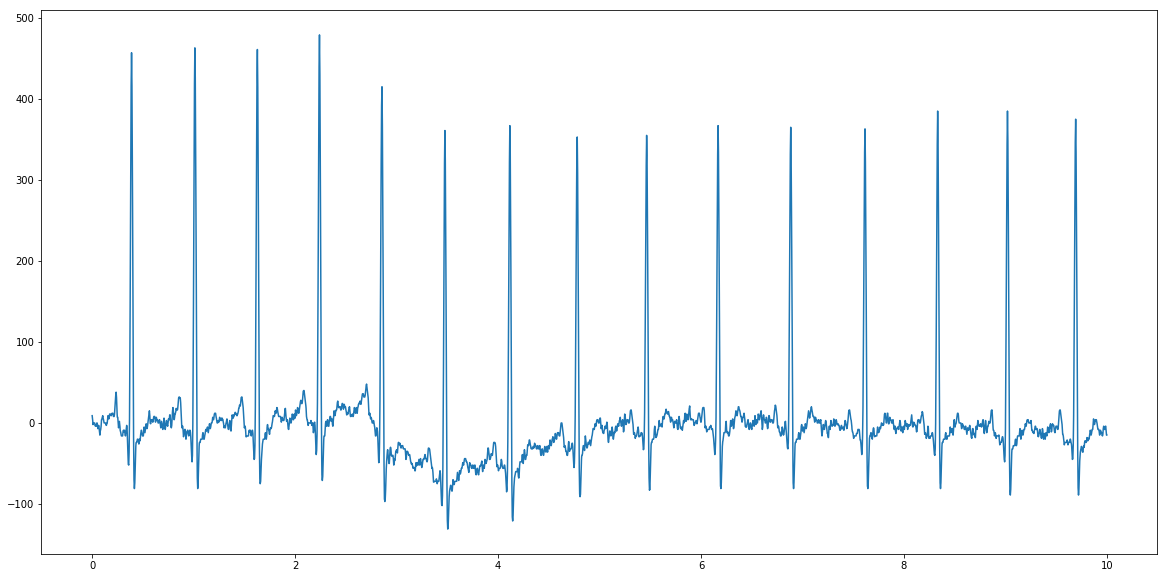

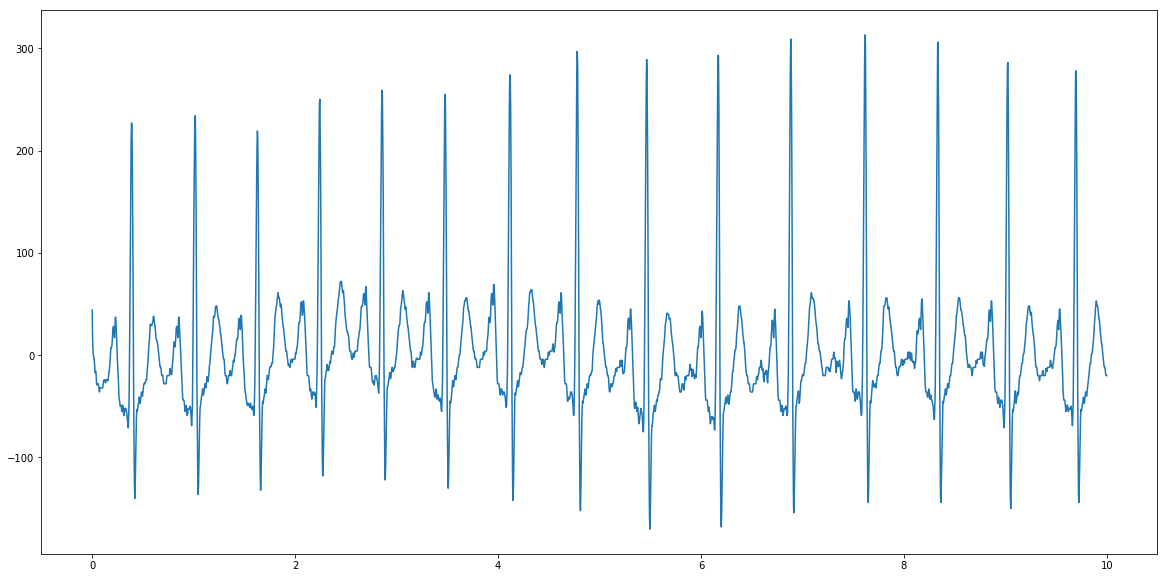

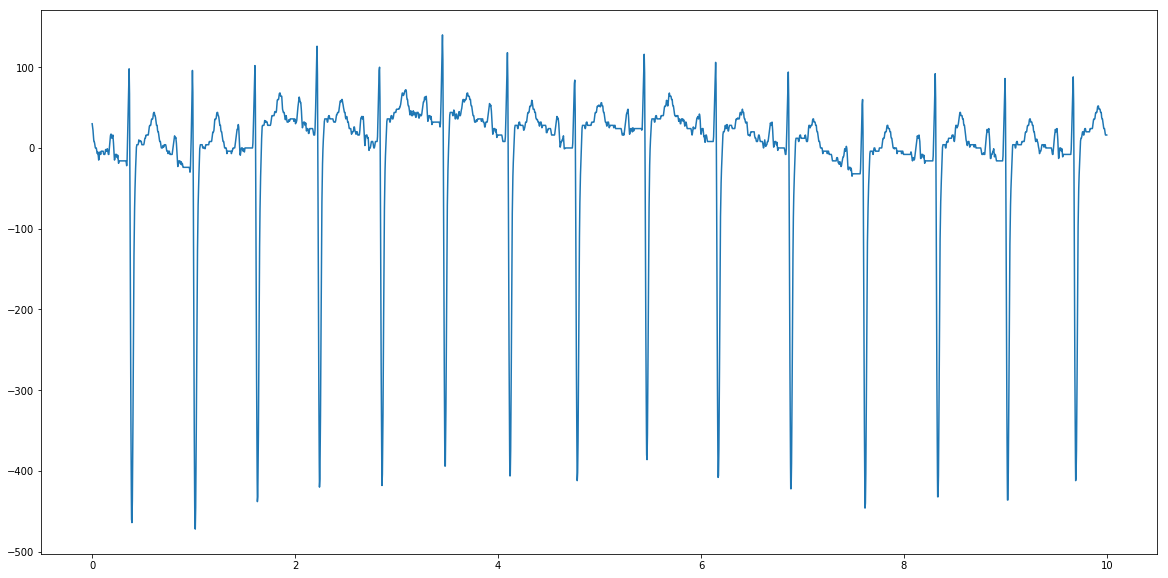

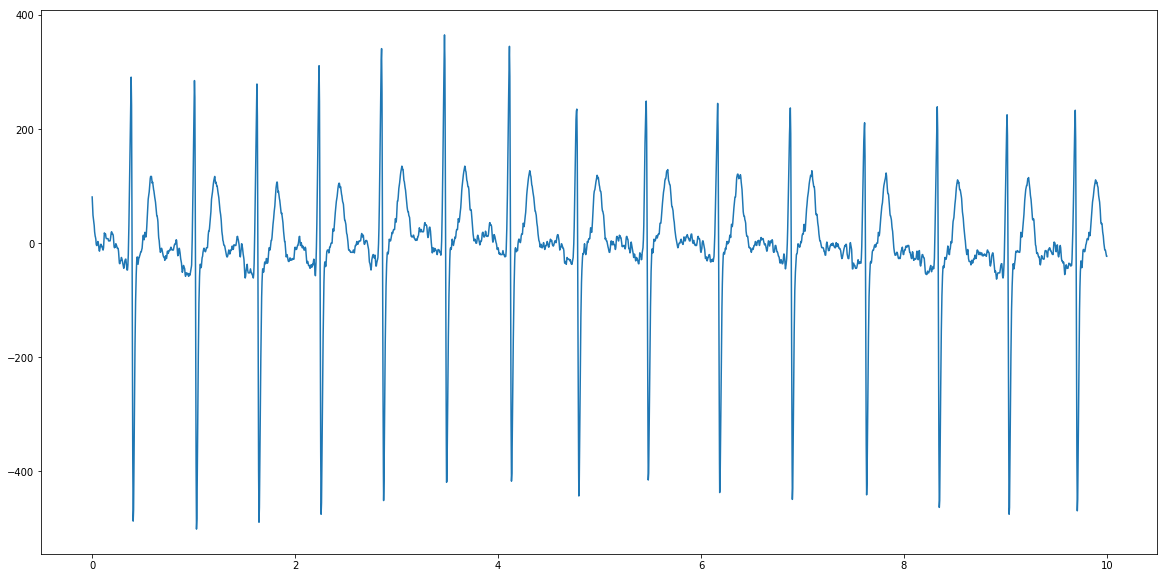

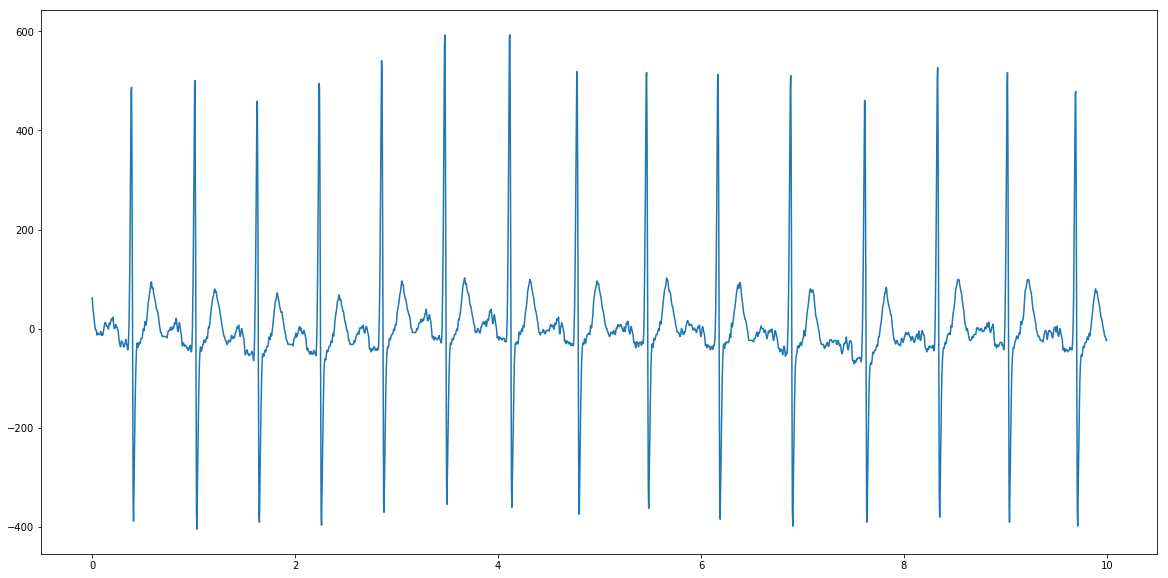

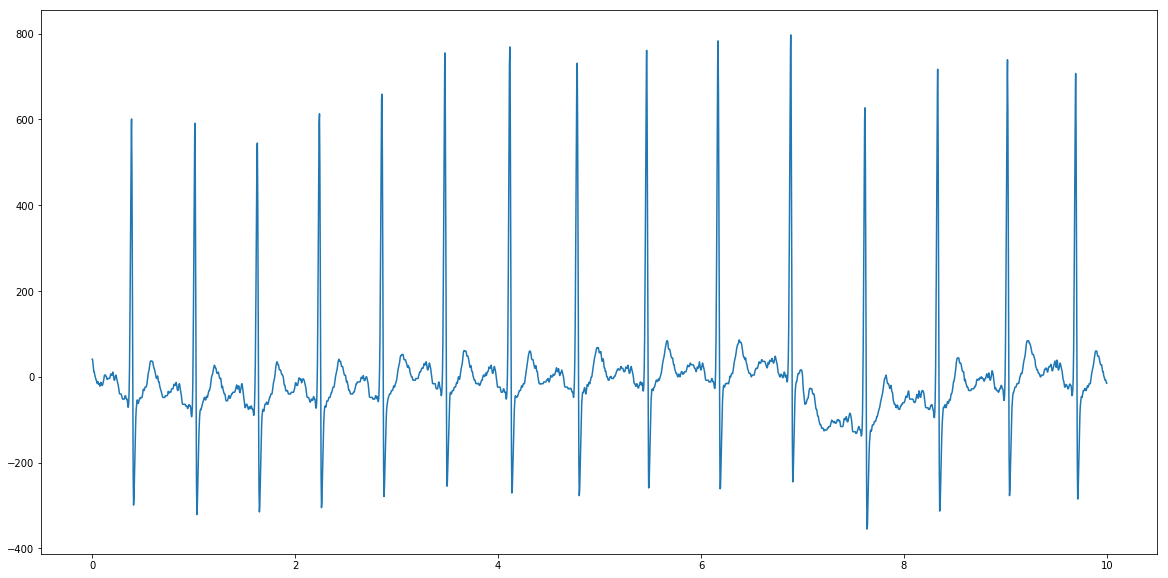

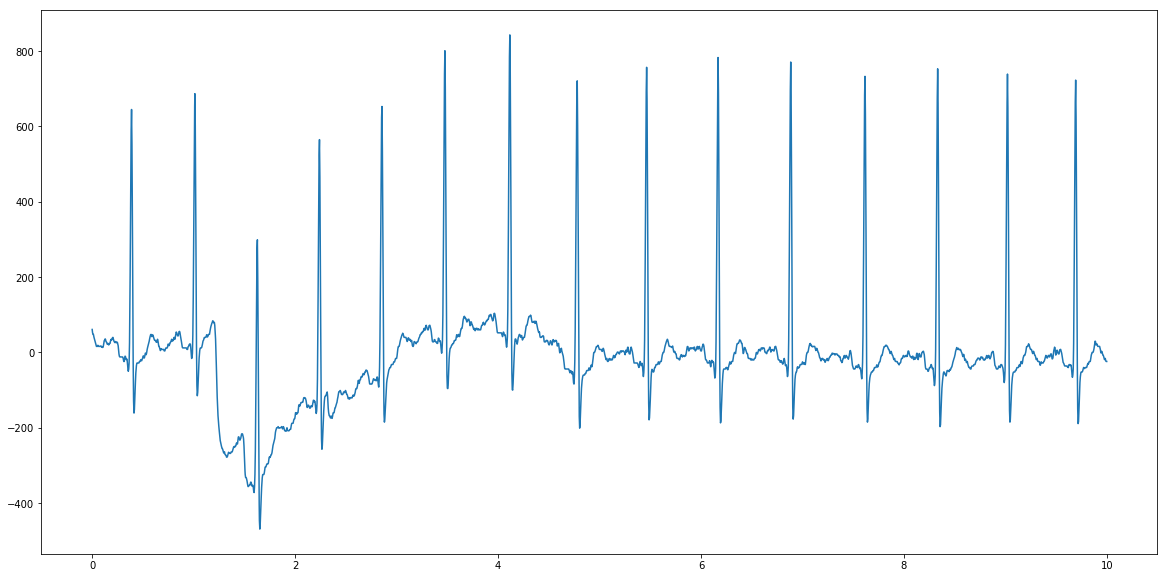

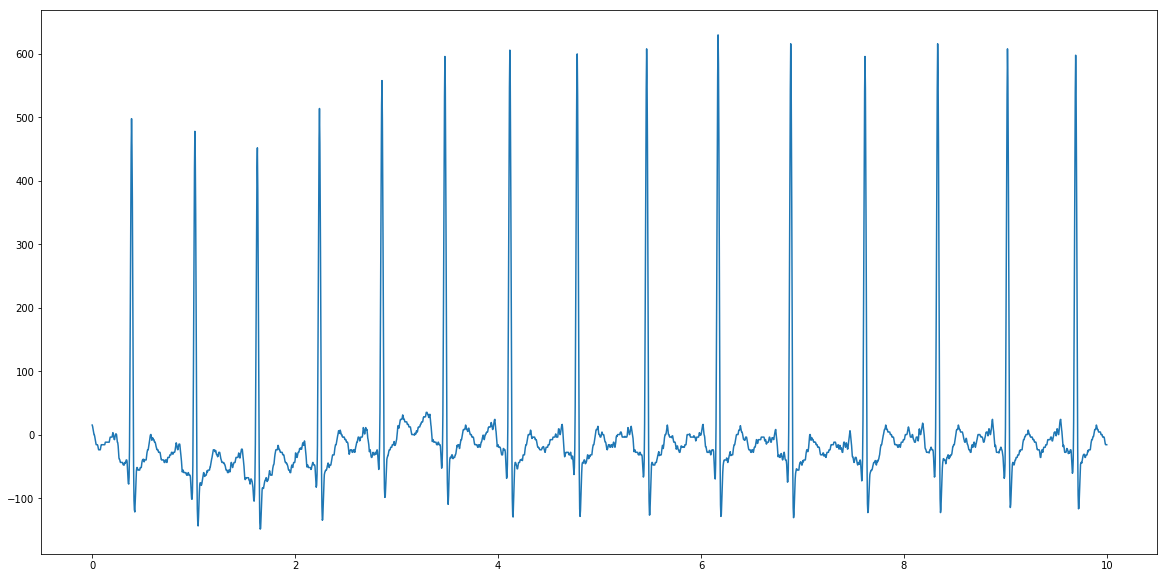

In [7]:
t = np.array(range(5000))*0.002
for j in range(8):
    plt.figure(figsize=[20,10])
    plt.plot(t, ecg_signals[0, j, :])
    plt.show()

In [8]:
# sg = scipy.signal.savgol_filter(ecg_signals[0,0,:], 333, 1, mode='wrap')
# plt.figure(figsize=[36,6])
# plt.plot(t, sg)
# plt.plot(t, ecg_signals[0,0,:])
# plt.plot(t, ecg_signals[0,0,:] - sg)
# plt.grid()

In [9]:
# sg = scipy.signal.savgol_filter(ecg_signals[0,6,:], 333, 1)
# plt.figure(figsize=[36,6])
# plt.plot(t, sg)
# plt.plot(t, ecg_signals[0,6,:])
# plt.plot(t, ecg_signals[0,6,:] - sg)
# plt.grid()

In [10]:
# m = np.median(ecg_signals[0,0,:])
# new_ecg_signals = ecg_signals[0,0,:] - m
# p = np.polyfit(t, new_ecg_signals, 4)
# poly4 = np.polyval(p, t)
# new_ecg_signals = new_ecg_signals - poly4

In [11]:
# plt.figure(figsize=[36,6])
# plt.plot(t, ecg_signals[0,0,:])
# plt.plot(t, poly4)
# sg4 = scipy.signal.savgol_filter(ecg_signals[0,0,:], 333, 1)
# plt.plot(t, sg4)

In [12]:
def high_pass_filter(signal, order, cutoff, fs):
    nyq = 0.5 * fs
    normal_cutoff = cutoff/nyq
    b, a = scipy.signal.butter(order, normal_cutoff, btype='high')
    filtered_signal = scipy.signal.filtfilt(b, a, signal)
    return filtered_signal

In [13]:
# filtered = high_pass_filter(ecg_signals[0,0,:], 5, 1.5, 500)
# plt.figure(figsize=[36,6])
# plt.plot(t, filtered)
# plt.plot(t, ecg_signals[0,0,:])
# plt.grid()
# plt.show()

In [14]:
# filtered = high_pass_filter(ecg_signals[0,6,:], 5, 1.5, 500)
# plt.figure(figsize=[36,6])
# plt.plot(t, filtered)
# plt.plot(t, ecg_signals[0,6,:])
# plt.grid()
# plt.show()

In [15]:
# filtered = high_pass_filter(ecg_signals[20,0,:], 5, 1, 500)
# plt.figure(figsize=[36,6])
# plt.plot(t, filtered)
# plt.plot(t, ecg_signals[20,0,:])
# plt.grid()
# plt.show()

In [16]:
# filtered_ecg_signals = np.zeros((30, 8, 5000))
# n1 = np.zeros((30))

# for i in range(30):
#     n_peaks = []
#     for j in range(8):
#         filtered_signal = high_pass_filter(ecg_signals[i,j,:],5,1,500)
#         m = filtered_signal.max() * 0.5
#         peaks, _ = scipy.signal.find_peaks(filtered_signal, height=m)
#         n_peaks.append(len(peaks))
#     n1[i] = scipy.stats.mode(n_peaks)[0][0]
#     for k in range(8):
#         filtered_ecg_signals[i,k,:] = high_pass_filter(ecg_signals[i,k,:], 5, n1[i]/10, 500)

In [17]:
# filtered_ecg_signals = np.zeros((30, 8, 5000))
# n2 = np.zeros((30))

# for i in range(30):
#     n_peaks = []
#     for j in range(8):
#         filtered_signal = high_pass_filter(ecg_signals[i,j,:],5,1,500)
#         m = filtered_signal.max() * 0.75
#         peaks, _ = scipy.signal.find_peaks(filtered_signal, height=m)
#         n_peaks.append(len(peaks))
#     n2[i] = scipy.stats.mode(n_peaks)[0][0]
#     for k in range(8):
#         filtered_ecg_signals[i,k,:] = high_pass_filter(ecg_signals[i,k,:], 5, n2[i]/10, 500)

In [18]:
def autocorr(signal):
    return np.correlate(signal, signal, mode='full')

In [19]:
def root_sum_square(array):
    return np.sqrt(np.sum(array[:] ** 2)) 

In [20]:
filtered_ecg_signals = np.zeros((30, 8, 5000))
n = np.zeros((30))

autocorr_t = np.array(range(-4999,5000))*0.002
autocorr_signal = np.zeros((30,8,9999))
autocorr_auc = np.zeros((30,8))

for i in range(30):
    n_peaks = []
    for j in range(8):
        filtered_signal = high_pass_filter(ecg_signals[i,j,:],5,1,500)
        if abs(filtered_signal.min()) > filtered_signal.max():
            filtered_signal = - 1 * filtered_signal
        m = filtered_signal.max() * 0.5
        peaks, _ = scipy.signal.find_peaks(filtered_signal, height=m)
        n_peaks.append(len(peaks))
    n[i] = scipy.stats.mode(n_peaks)[0][0]
    for k in range(8):
        filtered_ecg_signals[i,k,:] = high_pass_filter(ecg_signals[i,k,:], 5, n[i]/10, 500)
        autocorr_signal[i,k,:] = autocorr(filtered_ecg_signals[i,k,:])
        autocorr_signal[i,k,:] = autocorr_signal[i,k,:] / root_sum_square(autocorr_signal[i,k,:])
        autocorr_auc[i,k] = scipy.integrate.simps(abs(autocorr_signal[i,k,:]), autocorr_t)

In [21]:
n

array([15., 12., 11., 10., 12., 11., 13., 10., 11., 13.,  9.,  9., 11.,
       11., 10., 15., 11., 11.,  9., 11., 10., 11., 10., 12., 11., 12.,
       11., 12., 14., 10.])

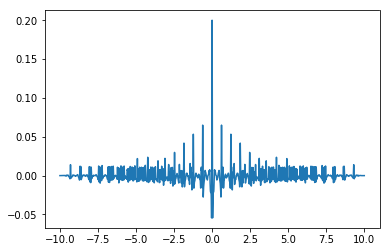

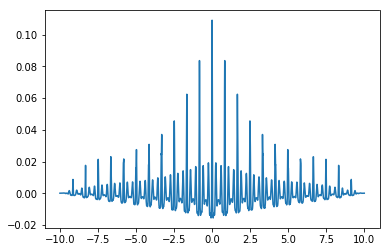

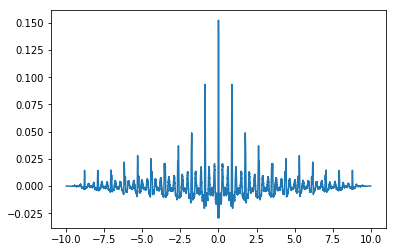

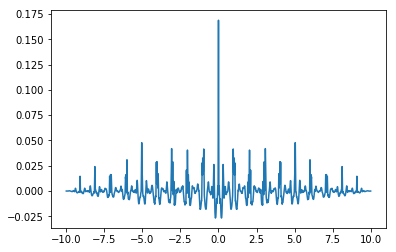

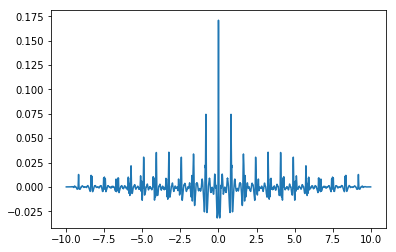

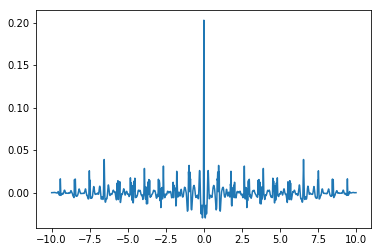

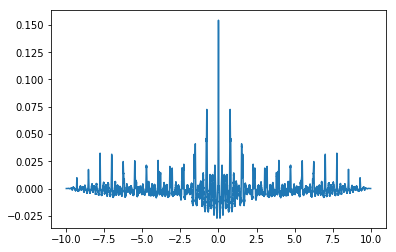

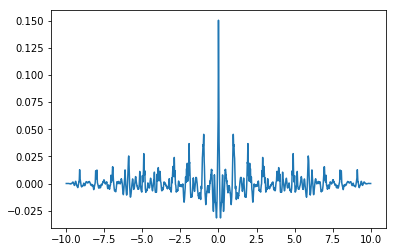

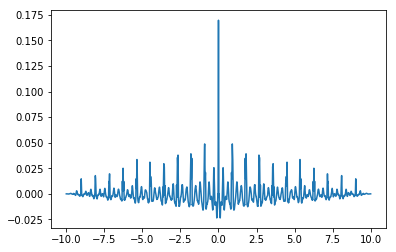

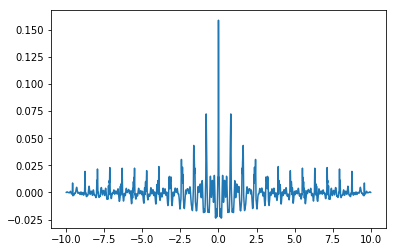

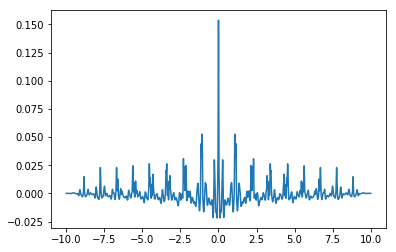

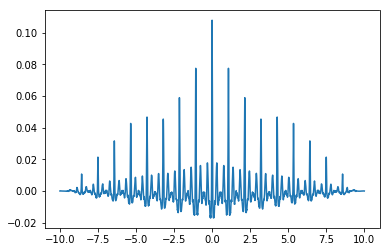

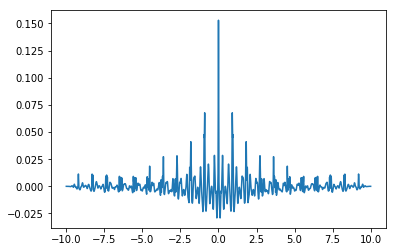

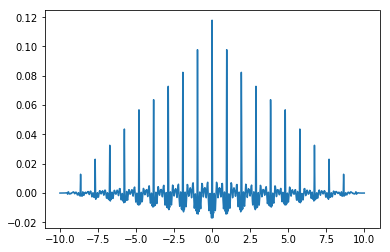

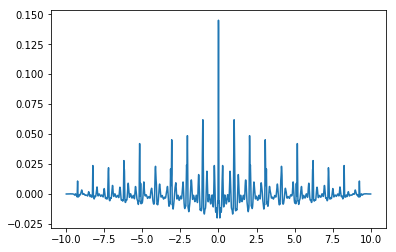

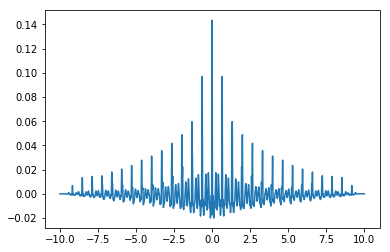

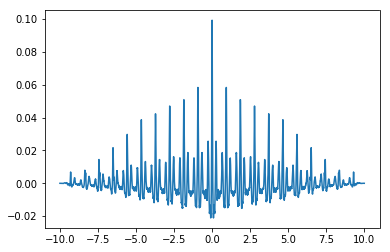

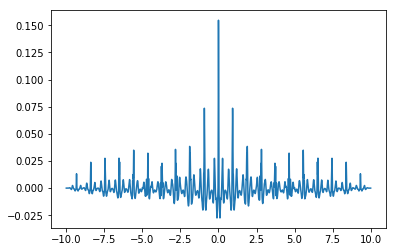

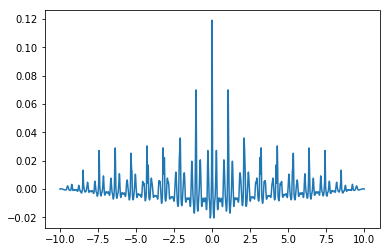

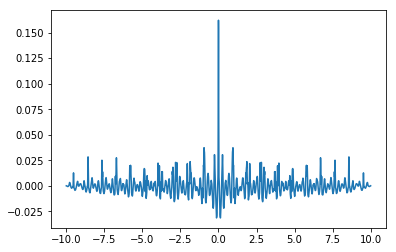

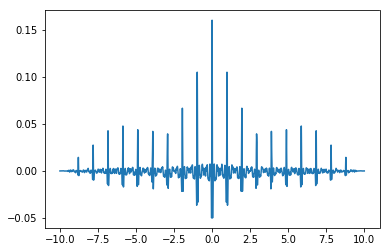

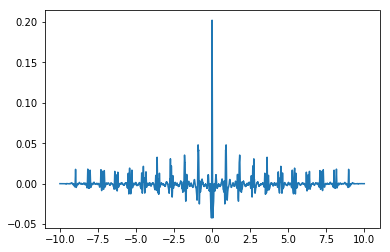

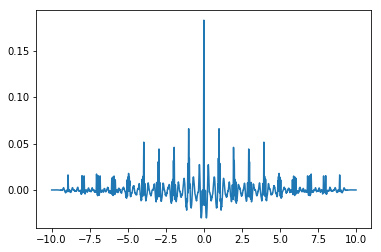

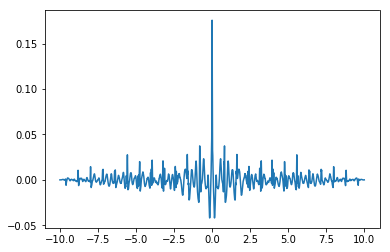

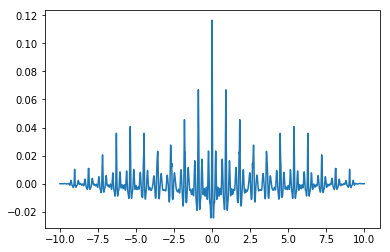

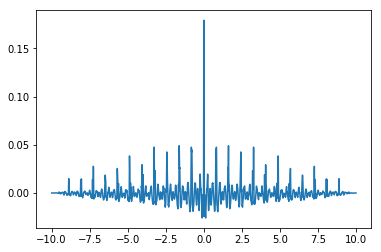

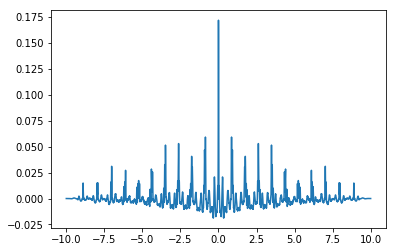

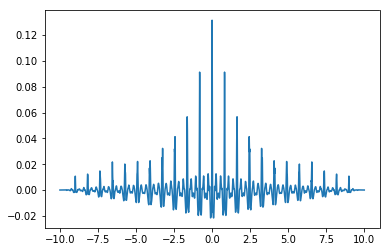

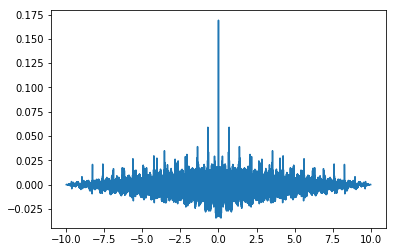

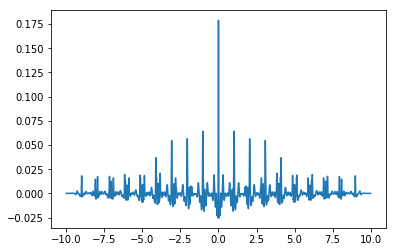

In [22]:
for i in range(30):
    plt.plot(autocorr_t, autocorr_signal[i,0,:])
    plt.show()

In [23]:
def Fourier_transform(freq, time, signal):
    assert isinstance(freq, np.ndarray)
    ft_result = np.zeros(freq.shape, dtype=complex)
    for l in range(len(freq)):
        s = 0
        for k in range(2, len(time)):
            s += ((signal[k] - signal[k-1]) / (time[k] - time[k-1])) * (cmath.exp(-1j*freq[l]*time[k-1]) - cmath.exp(-1j*freq[l]*time[k]))
        ft_signal = - (freq[l] * 1j + (1 - cmath.exp(- 1j * freq[l] * time[1])) * (signal[1] - 1) / time[1] + s) / freq[l]**2
        ft_result[l] = ft_signal
    return np.multiply(ft_result, freq) * 1j

In [24]:
def cs_oversample(t, signal, factor):
    cs_interpolator = CubicSpline(t, signal)
    num = len(t) * factor
    oversampled_t = np.linspace(0,10,num=num,endpoint=False)
    interpolated_signal = cs_interpolator(oversampled_t)
    return oversampled_t, interpolated_signal

In [25]:
ft_autocorr_signal = np.zeros((30,8,1000), dtype=complex)
freq = np.array([0.1 * w for w in range(1,1001)])

for i in range(30):
    for j in range(8):
        oversampled_t, interpolated_signal = cs_oversample(t, autocorr_signal[i,j,4999:], 1)
        ft_autocorr_signal[i,j] = Fourier_transform(freq, oversampled_t, interpolated_signal)
        print(str(i)+','+str(j)+'finished')

0,0finished
0,1finished
0,2finished
0,3finished
0,4finished
0,5finished
0,6finished
0,7finished
1,0finished
1,1finished
1,2finished
1,3finished
1,4finished
1,5finished
1,6finished
1,7finished
2,0finished
2,1finished
2,2finished
2,3finished
2,4finished
2,5finished
2,6finished
2,7finished
3,0finished
3,1finished
3,2finished
3,3finished
3,4finished
3,5finished
3,6finished
3,7finished
4,0finished
4,1finished
4,2finished
4,3finished
4,4finished
4,5finished
4,6finished
4,7finished
5,0finished
5,1finished
5,2finished
5,3finished
5,4finished
5,5finished
5,6finished
5,7finished
6,0finished
6,1finished
6,2finished
6,3finished
6,4finished
6,5finished
6,6finished
6,7finished
7,0finished
7,1finished
7,2finished
7,3finished
7,4finished
7,5finished
7,6finished
7,7finished
8,0finished
8,1finished
8,2finished
8,3finished
8,4finished
8,5finished
8,6finished
8,7finished
9,0finished
9,1finished
9,2finished
9,3finished
9,4finished
9,5finished
9,6finished
9,7finished
10,0finished
10,1finished
10,2finished
1

In [26]:
a,b = cs_oversample(t, autocorr_signal[0,0,4999:],4)

In [27]:
Fourier_transform(freq, a, b)

array([-1.06620587e-06+2.02260024e-05j, -4.45841166e-06+4.06672717e-05j,
       -9.79663529e-06+6.12537628e-05j, -1.70462264e-05+8.16888769e-05j,
       -2.64950757e-05+1.01803842e-04j, -3.84536897e-05+1.21806014e-04j,
       -5.28741359e-05+1.42106081e-04j, -6.93303954e-05+1.62866326e-04j,
       -8.74416900e-05+1.83754404e-04j, -1.07325018e-04+2.04219835e-04j,
       -1.29570708e-04+2.24066830e-04j, -1.54691564e-04+2.43735292e-04j,
       -1.82565647e-04+2.63937622e-04j, -2.12472122e-04+2.84946301e-04j,
       -2.43767089e-04+3.06240271e-04j, -2.76575981e-04+3.26931582e-04j,
       -3.11782940e-04+3.46630168e-04j, -3.50239592e-04+3.65908070e-04j,
       -3.91910646e-04+3.85838384e-04j, -4.35819865e-04+4.06971362e-04j,
       -4.80940730e-04+4.28722194e-04j, -5.27235971e-04+4.49832065e-04j,
       -5.75818505e-04+4.69551876e-04j, -6.27984115e-04+4.88438884e-04j,
       -6.83968072e-04+5.07935077e-04j, -7.42633178e-04+5.29028964e-04j,
       -8.02485105e-04+5.51239047e-04j, -8.63134906

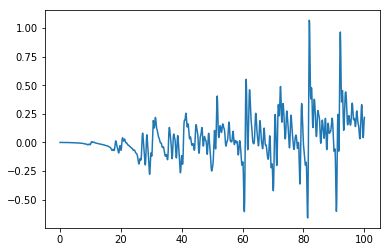

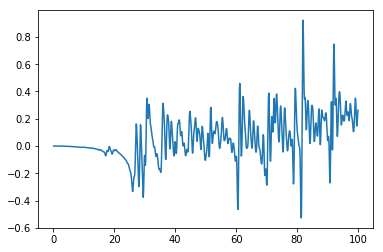

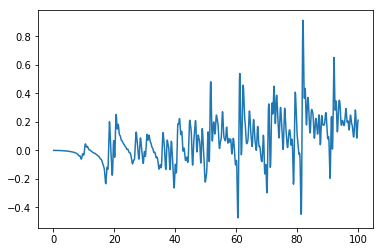

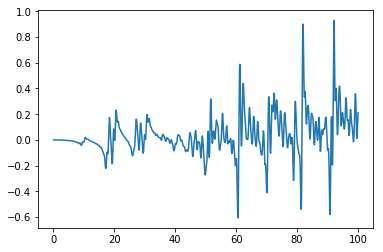

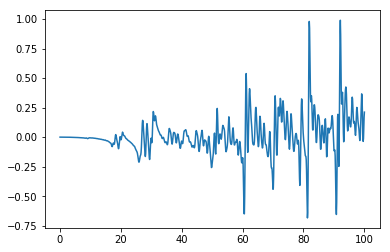

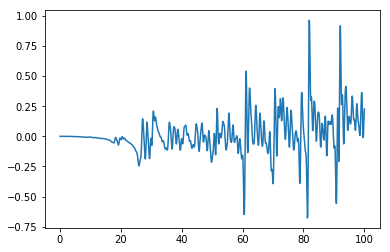

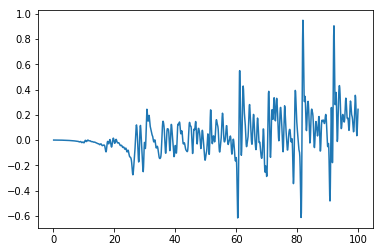

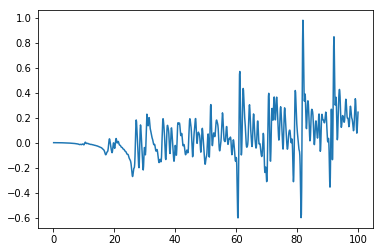

In [30]:
for i in range(8):
    plt.plot(freq, ft_autocorr_signal[0,i,:].real)
    plt.show()

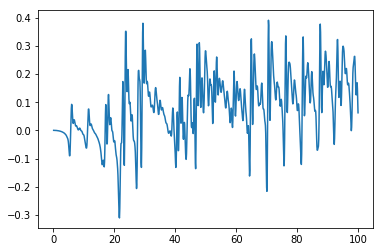

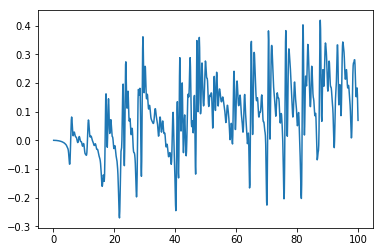

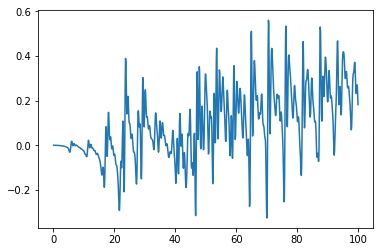

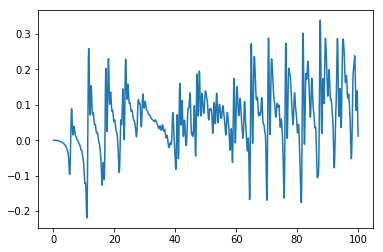

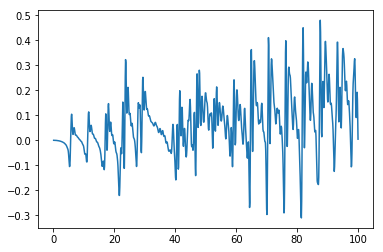

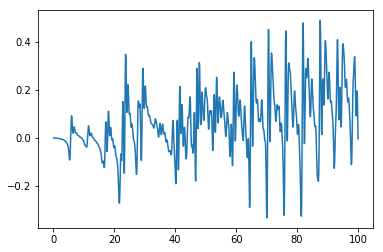

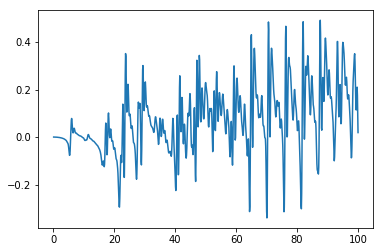

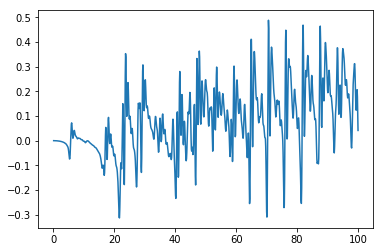

In [31]:
for i in range(8):
    plt.plot(freq, ft_autocorr_signal[10,i,:].real)
    plt.show()

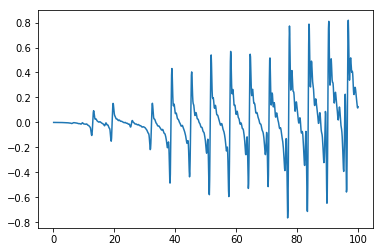

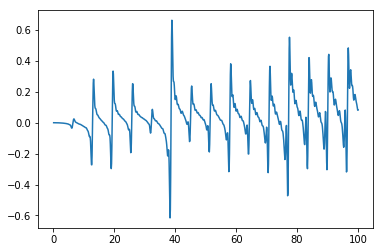

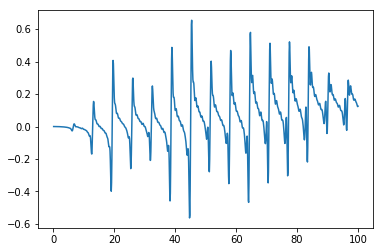

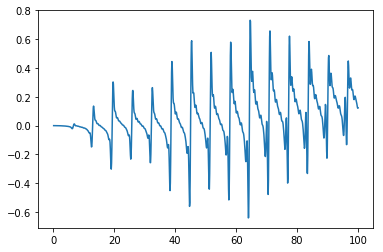

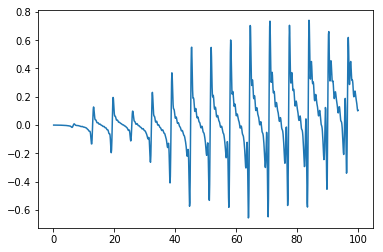

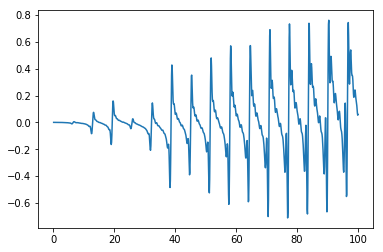

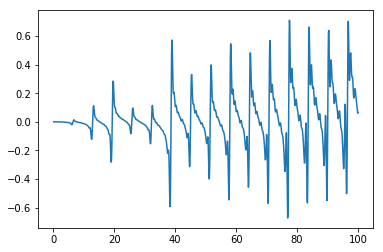

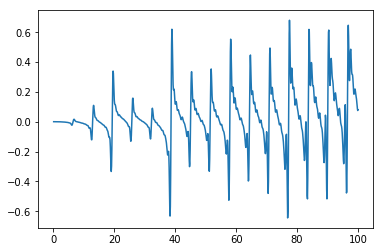

In [32]:
for i in range(8):
    plt.plot(freq, ft_autocorr_signal[20,i,:].real)
    plt.show()